In [6]:
import auraloss
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sys
import torch

import cnn
import synth

sys.path.append('../dcase2023_task7_eval_fad')
import audioset_model

mss_distance = auraloss.freq.MultiResolutionSTFTLoss()

def model_distance(model, x, y):
    x_np = x[384:-384].detach().numpy()
    y_np = y[384:-384].detach().numpy()
    x_logmel = model.extract_features(x_np)
    y_logmel = model.extract_features(y_np)
    x_logmel = np.stack(x_logmel, axis=0).mean(axis=0)
    y_logmel = np.stack(y_logmel, axis=0).mean(axis=0)
    x_vgg = model.process_batch(x_logmel)
    y_vgg = model.process_batch(y_logmel)
    return np.linalg.norm(x_vgg - y_vgg)

checkpoint = '../dcase2023_task7_eval_fad/data/vggish_model.ckpt'
vggish = audioset_model.AudioSetModel(checkpoint)

distances = {
    'mss': lambda x,y: mss_distance(
        x.unsqueeze(0).unsqueeze(0), y.unsqueeze(0).unsqueeze(0)),
    'vgg': lambda x, y: model_distance(vggish, x, y)
}

n_densities = 7
n_slopes = 7
n_folds = n_densities * n_slopes
batch_size = 1

dataset = cnn.ChirpTextureDataModule(
    n_densities=n_densities,
    n_slopes=n_slopes,
    n_folds=n_folds,
    batch_size=batch_size)
dataset.setup()


/Users/user/miniconda3/envs/scrapl/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1694: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '
/Users/user/miniconda3/envs/scrapl/lib/python3.10/site-packages/tensorflow/python/keras/legacy_tf_layers/core.py:332: UserWarning: `tf.layers.flatten` is deprecated and will be removed in a future version. Please use `tf.keras.layers.Flatten` instead.
  warnings.warn('`tf.layers.flatten` is deprecated and '


INFO:tensorflow:Restoring parameters from ../dcase2023_task7_eval_fad/data/vggish_model.ckpt
CQT kernels created, time used = 0.0243 seconds
CQT kernels created, time used = 0.0215 seconds
CQT kernels created, time used = 0.0190 seconds


In [7]:
out = {}

for distance_key, distance in distances.items():

    # 0: matched seed between x and y
    # 1: difference seed between x and y
    for seed in [0, 1]:

        y = synth.generate_chirp_texture(
                theta_density=torch.tensor(0.5),
                theta_slope=torch.tensor(0.),
                duration=dataset.train_ds.duration,
                event_duration=dataset.train_ds.event_duration,
                sr=dataset.train_ds.sr,
                fmin=dataset.train_ds.fmin,
                fmax=dataset.train_ds.fmax,
                n_events=dataset.train_ds.n_events,
                Q=dataset.train_ds.Q,
                hop_length=dataset.train_ds.hop_length,
                seed=seed,
            )

        X = {}
        sp_df = pd.DataFrame(columns=[
            "density_idx", "slope_idx", "distance", "density_grad", "slope_grad"])
        for _, row in dataset.df.iterrows():
            theta_density = torch.tensor(row["density"], requires_grad=True)
            theta_slope = torch.tensor(row["slope"], requires_grad=True)
            x = synth.generate_chirp_texture(
                theta_density=theta_density,
                theta_slope=theta_slope,
                duration=dataset.train_ds.duration,
                event_duration=dataset.train_ds.event_duration,
                sr=dataset.train_ds.sr,
                fmin=dataset.train_ds.fmin,
                fmax=dataset.train_ds.fmax,
                n_events=dataset.train_ds.n_events,
                Q=dataset.train_ds.Q,
                hop_length=dataset.train_ds.hop_length,
                seed=0,
            )
            xy_dist = distance(x, y)
            if hasattr(xy_dist, 'backward'):
                xy_dist.backward()
            if theta_density.grad is None:
                theta_density.grad = torch.zeros_like(theta_density)
            if theta_slope.grad is None:
                theta_slope.grad = torch.zeros_like(theta_slope)
            sp_row = {
                "density_idx": int(row['density_idx']),
                "slope_idx": int(row['slope_idx']),
                "distance": xy_dist.item(),
                "density_grad": -theta_density.grad.item(),
                "slope_grad": -theta_slope.grad.item(),
            }
            sp_df.loc[len(sp_df)] = sp_row
        out[(distance_key, seed)] = sp_df

/Users/user/miniconda3/envs/scrapl/lib/python3.10/site-packages/matplotlib/quiver.py:646: RuntimeWarning: divide by zero encountered in double_scalars
  length = a * (widthu_per_lenu / (self.scale * self.width))
/Users/user/miniconda3/envs/scrapl/lib/python3.10/site-packages/matplotlib/quiver.py:646: RuntimeWarning: invalid value encountered in multiply
  length = a * (widthu_per_lenu / (self.scale * self.width))


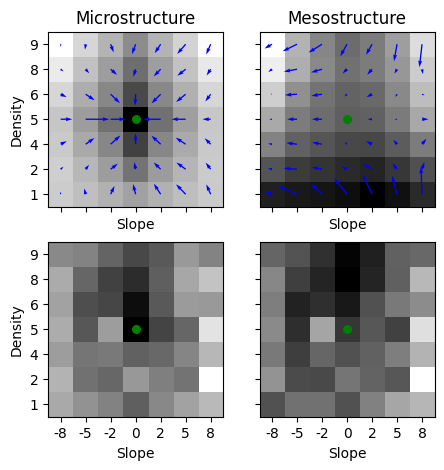

In [8]:
side_length = 2.5
fig, axes = plt.subplots(2, 2, figsize=(2*side_length, 2*side_length), sharex=True, sharey=True)

for distance_id, distance_key in enumerate(distances.keys()):
    for seed in [0, 1]:
        ax = axes[distance_id, seed]
        df = out[(distance_key, seed)]

        distance_field = np.zeros((n_densities, n_slopes))
        for density_idx in range(n_densities):
            for slope_idx in range(n_slopes):
                distance_field[density_idx, slope_idx] = df[
                    (df['density_idx'] == density_idx) &
                    (df['slope_idx'] == slope_idx)
                ]['distance'].item()

        ax.imshow(distance_field, cmap='gray')
        ax.quiver(
            df['density_idx'], df['slope_idx'],
            df['density_grad'], df['slope_grad'],
            color='blue',
        )
        # show green dot at the center
        ax.scatter([3], [3], color='green', marker='o', s=30)
        ax.set_xlabel('Slope')
        ax.set_xticks(np.arange(n_slopes))
        ax.set_xticklabels([
            "{:.0f}".format(10*xt) for xt in
            np.linspace(-1, 1, n_slopes+2)[1:-1]])
        ax.set_yticks(np.arange(n_slopes))
        ax.set_yticklabels([
            "{:.0f}".format(10*xt) for xt in
            np.linspace(0, 1, n_densities+2)[1:-1]])
        if seed==0:
            ax.set_ylabel('Density')
        ax.invert_yaxis()

        if distance_id==0:
            if seed==0:
                ax.set_title('Microstructure')
            else:
                ax.set_title('Mesostructure')

    #plt.savefig('gradient_field.png', dpi=300)  
